<a href="https://colab.research.google.com/github/utkarshkant/Multiple-Time-Series-Modelling-with-PySpark-and-FB-Prophet/blob/main/Multiple_Time_Series_Modelling_with_PySpark_and_FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Time Series Modelling with Apache Spark and FB Prophet

In [1]:
# install java 8 compatible with Apache Spark
# !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
# import os
# os.environ["JAVA HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

In [2]:
# check java version
!java -version

java version "19.0.1" 2022-10-18
Java(TM) SE Runtime Environment (build 19.0.1+10-21)
Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)


In [3]:
# install pyspark
# !pip install pyspark

In [4]:
# install pyarrow
# !pip install pyarrow==0.15.1  # package for transferring data from one technology to another

In [5]:
!pip show pyarrow

Name: pyarrow
Version: 8.0.0
Summary: Python library for Apache Arrow
Home-page: https://arrow.apache.org/
Author: 
Author-email: 
License: Apache License, Version 2.0
Location: /opt/homebrew/Caskroom/miniconda/base/envs/ml38/lib/python3.8/site-packages
Requires: numpy
Required-by: streamlit


In [6]:
# install fbprophet
# !pip install fbprophet

In [7]:
# standard imports
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet   # for time series modelling

# configurations
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

In [8]:
# initializing a spark session
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [9]:
# load dataset
df = pd.read_csv('dataset/air_quality_index.csv')

In [10]:
# preview dataset
df

,DATE,COUNTRY,CITY,VALUE
0,2019-01-01,US,San Antonio,42.0
1,2019-01-01,US,Saint Paul,21.0
2,2019-01-01,US,Denver,42.0
3,2019-01-01,US,San Francisco,13.0
4,2019-01-01,US,Madison,14.0
...,...,...,...,...
68983,2021-05-31,US,Detroit,42.0
68984,2021-05-31,US,Jackson,30.0
68985,2021-05-31,US,The Bronx,12.0
68986,2021-05-31,US,Manhattan,13.0


In [11]:
# size of dataset
print("# Rows:", df.shape[0])
print("# Cols:", df.shape[1])

# Rows: 68988
# Cols: 4


In [12]:
# metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68988 entries, 0 to 68987
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     68988 non-null  object 
 1   COUNTRY  68988 non-null  object 
 2   CITY     68988 non-null  object 
 3   VALUE    68988 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


- Data contains weekly sales data, i.e., the weekly sales per store id
- `date` feature is not in datetime format

In [13]:
# check for missing values
df.isnull().sum()

DATE       0
COUNTRY    0
CITY       0
VALUE      0
dtype: int64

- no missing data found

In [14]:
# convert 'date' feature into datetime
df['DATE'] = pd.to_datetime(df['DATE'], infer_datetime_format=True)

In [15]:
# metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68988 entries, 0 to 68987
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     68988 non-null  datetime64[ns]
 1   COUNTRY  68988 non-null  object        
 2   CITY     68988 non-null  object        
 3   VALUE    68988 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.1+ MB


In [16]:
# unique values
df.nunique()

DATE       852
COUNTRY      2
CITY        80
VALUE      424
dtype: int64

- there are 50 unique date values and 
- 10 unique store ids

We will build 10 different time-series models for the 10 different store ids and run them together

In [17]:
# create a backup copy of the dataset
df_1 = df.copy()

In [18]:
# metadata
df.describe()

,VALUE
count,68988.000000
mean,54.766032
std,51.323430
min,1.000000
25%,23.000000
50%,35.000000
75%,63.000000
max,834.000000


In [19]:
# explore features
df['COUNTRY'].value_counts()

US    49809
IN    19179
Name: COUNTRY, dtype: int64

- each store has data records

In [20]:
# set date as index
df_ts = df.set_index('DATE')

In [21]:
# preview dataset
df_ts

,COUNTRY,CITY,VALUE
DATE,,,
2019-01-01,US,San Antonio,42.0
2019-01-01,US,Saint Paul,21.0
2019-01-01,US,Denver,42.0
2019-01-01,US,San Francisco,13.0
2019-01-01,US,Madison,14.0
...,...,...,...
2021-05-31,US,Detroit,42.0
2021-05-31,US,Jackson,30.0
2021-05-31,US,The Bronx,12.0


<AxesSubplot:xlabel='DATE'>

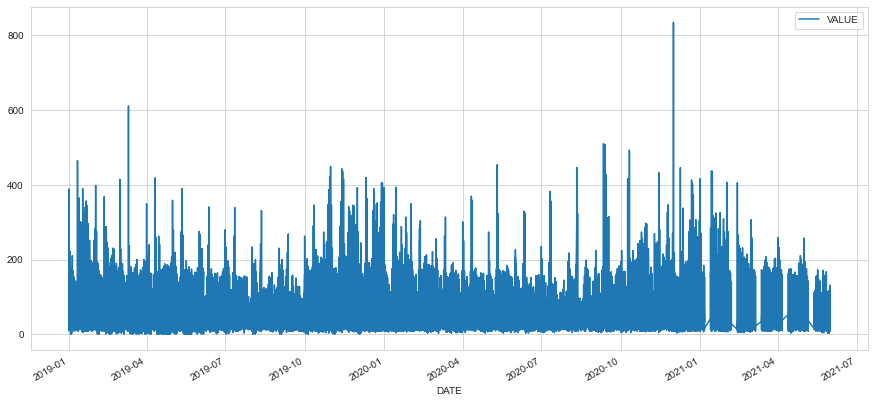

In [22]:
# explore individual stores
plt.figure(figsize=(15,7))
# df_ts.query("COUNTRY==US")['VALUE'].plot(legend=True)
df_ts['VALUE'].plot(legend=True)

- Multiple peaks and troughs on monthly basis
- Sharp dip nearing year-end in November

In [52]:
# explore individual stores
plt.figure(figsize=(15,7))
df_ts['COUNTRY'] = df['COUNTRY'].astype(str)

# df_ts.query("COUNTRY==IN")['VALUE'].plot(legend=True)

<Figure size 1080x504 with 0 Axes>

- Multiple peaks and troughs on monthly basis
- No sharp dip nearing year-end in November

In [53]:
# explore individual stores
plt.figure(figsize=(15,7))
# df_ts.query("store_id==30")['sales'].plot(legend=True)

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

- The time series for each store is different from one another
- Therefore, each store requires its individual time-series model

Build Spark Components

In [54]:
# build spark dataframe
sdf = spark.createDataFrame(df)

In [55]:
# preview spark dataframe
sdf.show(5)

+-------------------+-------+-------------+-----+
|               DATE|COUNTRY|         CITY|VALUE|
+-------------------+-------+-------------+-----+
|2019-01-01 00:00:00|     US|  San Antonio| 42.0|
|2019-01-01 00:00:00|     US|   Saint Paul| 21.0|
|2019-01-01 00:00:00|     US|       Denver| 42.0|
|2019-01-01 00:00:00|     US|San Francisco| 13.0|
|2019-01-01 00:00:00|     US|      Madison| 14.0|
+-------------------+-------+-------------+-----+
only showing top 5 rows



In [56]:
# metadata
sdf.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- VALUE: double (nullable = true)



In [57]:
# size of dataset
sdf.count()

68988

In [61]:
# data records per store
sdf.select(['CITY']).groupBy('CITY').agg({"CITY":"count"}).show()

+-------------+-----------+
|         CITY|count(CITY)|
+-------------+-----------+
|  Springfield|        881|
|    The Bronx|        858|
|      Phoenix|        894|
|        Hāpur|        880|
|       Queens|        894|
|        Omaha|        894|
|       Mysore|        508|
|       Dallas|        881|
|      Oakland|        894|
|  San Antonio|        891|
|      Raleigh|        893|
| Philadelphia|        889|
|        Patna|        893|
|  Los Angeles|        894|
|      Chennai|        893|
|   Sacramento|        890|
|      Lucknow|        893|
| Indianapolis|        881|
|San Francisco|        894|
|    San Diego|        709|
+-------------+-----------+
only showing top 20 rows



Now we need to partition the spark data into multiple partitions based on the store ids

In [59]:
# create temporary spark view
sdf.createOrReplaceTempView("VALUE")

In [60]:
# spark.sql("SELECT store_id, COUNT(*) FROM sales GROUP BY store_id ORDER BY store_id").show()

In [67]:
# create a SQL query
sql = "SELECT CITY, DATE AS ds, SUM(VALUE) as y FROM VALUE GROUP BY CITY, ds ORDER BY CITY, ds"

In [68]:
# preview data
spark.sql(sql).show()

+-----------+-------------------+----+
|       CITY|                 ds|   y|
+-----------+-------------------+----+
|Albuquerque|2019-01-01 00:00:00|25.0|
|Albuquerque|2019-01-02 00:00:00|40.0|
|Albuquerque|2019-01-03 00:00:00|15.0|
|Albuquerque|2019-01-04 00:00:00|33.0|
|Albuquerque|2019-01-05 00:00:00|16.0|
|Albuquerque|2019-01-06 00:00:00|33.0|
|Albuquerque|2019-01-07 00:00:00|20.0|
|Albuquerque|2019-01-08 00:00:00|23.0|
|Albuquerque|2019-01-09 00:00:00|25.0|
|Albuquerque|2019-01-10 00:00:00|36.0|
|Albuquerque|2019-01-11 00:00:00|25.0|
|Albuquerque|2019-01-12 00:00:00|18.0|
|Albuquerque|2019-01-13 00:00:00|19.0|
|Albuquerque|2019-01-14 00:00:00|33.0|
|Albuquerque|2019-01-15 00:00:00|44.0|
|Albuquerque|2019-01-16 00:00:00|56.0|
|Albuquerque|2019-01-17 00:00:00|27.0|
|Albuquerque|2019-01-18 00:00:00| 8.0|
|Albuquerque|2019-01-19 00:00:00|12.0|
|Albuquerque|2019-01-20 00:00:00|15.0|
+-----------+-------------------+----+
only showing top 20 rows



- feature names `ds` and `y` is a requirement of `fbprophet`

In [69]:
sdf.explain()   # it has an RDD function

== Physical Plan ==
*(1) Scan ExistingRDD[DATE#0,COUNTRY#1,CITY#2,VALUE#3]




In [70]:
# check data partitions
sdf.rdd.getNumPartitions()

1

- data is still in a single partition
- we need to divide it into multiple partitions


In [71]:
# create internal cache to prevent repeated data fetching
store_part = (spark.sql(sql).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

AnalysisException: Column 'store_id' does not exist. Did you mean one of the following? [ds, y, value.CITY];
'RepartitionByExpression ['store_id], 1
+- Sort [CITY#2 ASC NULLS FIRST, ds#96 ASC NULLS FIRST], true
   +- Aggregate [CITY#2, DATE#0], [CITY#2, DATE#0 AS ds#96, sum(VALUE#3) AS y#97]
      +- SubqueryAlias value
         +- View (`VALUE`, [DATE#0,COUNTRY#1,CITY#2,VALUE#3])
            +- LogicalRDD [DATE#0, COUNTRY#1, CITY#2, VALUE#3], false


In [37]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [38]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#83, y#84]
   +- InMemoryRelation [store_id#1L, ds#83, y#84], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 1), false, [id=#147]
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST, 200), true, [id=#143]
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200), true, [id=#139]
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- *(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




- Multiple data partitions have been created



In [39]:
# create a schema

# import datatypes
from pyspark.sql.types import *
# create schema
result_schema = StructType([
                            StructField('ds', TimestampType()),
                            StructField('store_id', IntegerType()),
                            StructField('y', DoubleType()),
                            StructField('yhat', DoubleType()),
                            StructField('yhat_upper', DoubleType()),
                            StructField('yhat_lower', DoubleType())
                          ])

In [40]:
# UDF for fbprophet modelling
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)   # GROUPED_MAP allows you to vectorize group of rows from data
def forecast_sales(store_pd):
  # create fbprophet model
  model = Prophet(interval_width=0.95, # forecast with 95% confidence interval
                  seasonality_mode='multiplicative',  # because multiple peaks and troughs in data
                  weekly_seasonality=True,
                  yearly_seasonality=True)
  # train model
  model.fit(store_pd)

  # future dataframe - for how much time in future do you wish to forecast
  future_pd = model.make_future_dataframe(
      periods=5,  # forecast for next 5 periods/values
      freq='w'    # weekly forecast
  )

  # make forecast
  forecast_pd = model.predict(future_pd)

  # store results
  f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
  st_pd = store_pd[['ds', 'store_id', 'y']].set_index('ds')

  # create result dataframe
  results_pd = f_pd.join(st_pd, how='left')
  results_pd.reset_index(level=0, inplace=True)
  results_pd['store_pd'] = store_pd['store_id'].iloc[0]

  return results_pd[['ds', 'store_id', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [41]:
# append current date to store when you run this model
from pyspark.sql.functions import current_date

results = (
    store_part
      .groupBy('store_id')  # vectorize the columns
      .apply(forecast_sales)  # apply UDF
      .withColumn('training_date', current_date())
)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [42]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [43]:
# preview results
results.show(5)

+-------------------+--------+-----------+------------------+------------------+------------------+-------------+
|                 ds|store_id|          y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+--------+-----------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|736657.2267| 712575.0694095818| 964091.7223007476|486577.19159198273|   2020-10-07|
|2019-01-13 00:00:00|      25|696457.1717| 743751.7568979745| 979890.6595385578| 501378.2937120345|   2020-10-07|
|2019-01-20 00:00:00|      25| 996876.875| 972909.8778074606|1185029.2643246108| 738883.5986192742|   2020-10-07|
|2019-01-27 00:00:00|      25| 1029737.05|1034447.5557655566|1256880.3327057916| 798864.3835934855|   2020-10-07|
|2019-02-03 00:00:00|      25|1072873.705| 986365.7266813249| 1214181.404062533| 757418.1006287117|   2020-10-07|
+-------------------+--------+-----------+------------------+------------------+--------

In [44]:
# collate all partitions into 1 partition
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [45]:
# size of results
results.count()   # 5 weeks forecast for 10 stores, thus, 550 (500+50)

550

In [46]:
# create temp view
results.createOrReplaceTempView('forecasted')

In [47]:
# sql query to fetch results
spark.sql("SELECT store_id, COUNT(*) FROM forecasted GROUP BY store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      50|
|      28|      50|
|      26|      50|
|      44|      50|
|    null|      50|
|      41|      50|
|      35|      50|
|      38|      50|
|      25|      50|
|      29|      50|
|      30|      50|
+--------+--------+



- The null is for forecasted values

In [48]:
# convert spark DF to pandas
final_df = results.toPandas()
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25.0,7.366572e+05,7.125751e+05,9.640917e+05,486577.191592,2020-10-07
1,2019-01-13,25.0,6.964572e+05,7.437518e+05,9.798907e+05,501378.293712,2020-10-07
2,2019-01-20,25.0,9.968769e+05,9.729099e+05,1.185029e+06,738883.598619,2020-10-07
3,2019-01-27,25.0,1.029737e+06,1.034448e+06,1.256880e+06,798864.383593,2020-10-07
4,2019-02-03,25.0,1.072874e+06,9.863657e+05,1.214181e+06,757418.100629,2020-10-07
...,...,...,...,...,...,...,...
545,2019-12-22,NaN,NaN,6.265474e+04,1.269201e+05,-3924.519869,2020-10-07
546,2019-12-29,NaN,NaN,2.657442e+04,8.700684e+04,-37232.431873,2020-10-07
547,2020-01-05,NaN,NaN,8.801264e+03,7.093800e+04,-52601.231193,2020-10-07
548,2020-01-12,NaN,NaN,4.665900e+03,6.635060e+04,-62753.186888,2020-10-07


In [49]:
# create date as index
final_df = final_df.set_index('ds')

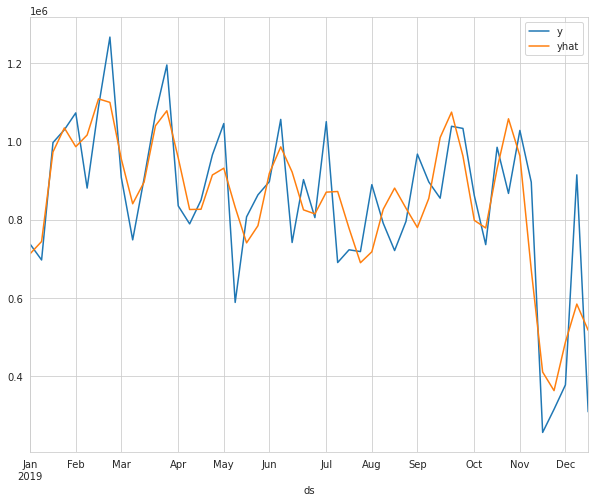

In [54]:
# explore individual stores
final_df.query("store_id==25")[['y', 'yhat']].plot(legend=True)

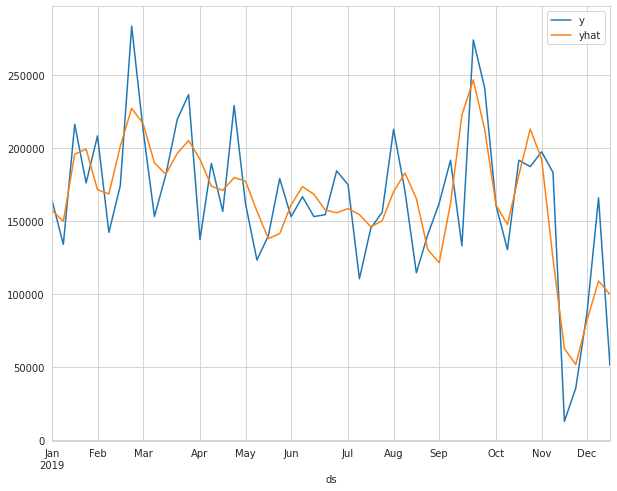

In [55]:
# explore individual stores
final_df.query("store_id==44")[['y', 'yhat']].plot(legend=True)

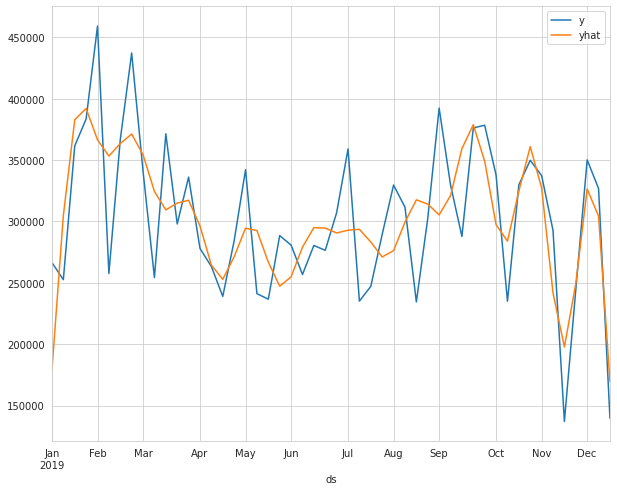

In [56]:
# explore individual stores
final_df.query("store_id==30")[['y', 'yhat']].plot(legend=True)